## Group I - HW2.1

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import operator

Sent row for each person should be in theory corresponding to receive column for that person, for example person 2 sents messages to people - People in  the receive sheet should note in column for  that person 2 that they were receiving messages from him/her. Since people taking part in the survey didn’t get specifications on how to quantify interactions with others, those aforementioned numbers vary to some extent. We therefore will analyze the average of corresponding rows/columns from „Sent”/”Receive” sheets to minimize the error introduced by problems with collecting the data.

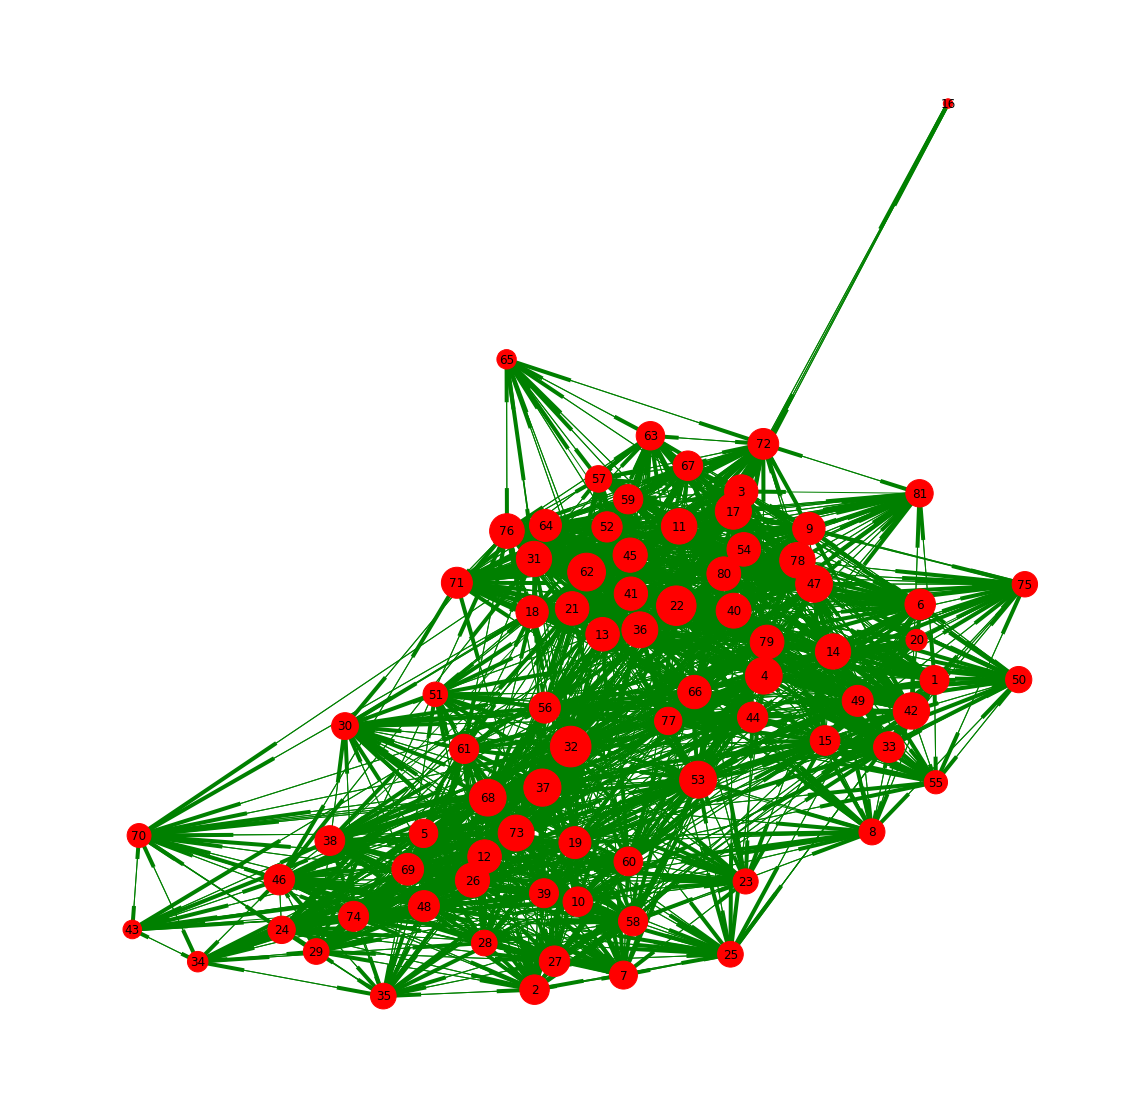

In [2]:
"""
 assigns spreadsheet filename and Loads spreadsheet
 loads both sheets from excel file into DataFrames, replaces NA's nd '-' with 0
 drops the first column
"""
interactions = r'C:\Users\Anka\Documents\Network Analytics\HW2_who_talks_to_whom.xlsx'
dfInteractions = pd.ExcelFile(interactions)
dfSent = dfInteractions.parse(dfInteractions.sheet_names[0]).fillna(0).replace(['-'], [0]).drop('Nodes', 1)
dfReceived = dfInteractions.parse(dfInteractions.sheet_names[1]).fillna(0).replace(['-'], [0]).drop('Nodes', 1)
dfSent.index = dfSent.columns
dfReceived.index = dfReceived.columns

dfReceived = dfReceived.transpose()
dfReceived.columns = dfReceived.index
dfSent.columns = dfReceived.index
dfSent.index = dfReceived.index

"""
 averaging sheets, Sent with transposed Receive - 
 in Sent sheet rows correspond to number of messages sent by those people to other
 in Receive sheet the columns correspond to the same number of sent messages 
 by those people but claimed by receivers
 therefore by taking this avarage we want to minimize the error introduced by obvious 
 problem in this task - how to quantify  the interactions with others from our cohort
"""
dfAverage = (dfReceived.add(dfSent, fill_value=0))/2
            
a = dfAverage.as_matrix()
G = nx.DiGraph(a)

"""
 define distance from one person to another as the inverse of number of messages
 so the more messages we sent the more we want this path to be chosen for BFS -
 in other words we want paths with highest values
 this will be used for closeness and betweenness centrality
"""            
dist = nx.get_edge_attributes(G, 'weight')
for k,v in dist.items():
    dist[k] = 1/v
nx.set_edge_attributes(G, dist, 'distance')

centralitydfAvg = pd.DataFrame()
centralitydfAvg['indeg'] = (dict(G.in_degree(weight=None))).values()
centralitydfAvg['outdeg'] = (dict(G.out_degree(weight = None))).values()
centralitydfAvg['degdiff'] = centralitydfAvg['indeg'].sub(centralitydfAvg['outdeg'])
centralitydfAvg['indeg_centr']=(nx.in_degree_centrality(G)).values()
centralitydfAvg['outdeg_centr']=(nx.out_degree_centrality(G)).values()
centralitydfAvg['eigen_centr']=(nx.eigenvector_centrality(G, max_iter=500)).values()
centralitydfAvg['closeness_centr'] = (nx.closeness_centrality(G, distance = 'distance')).values() #represents the closeness FROM this node
centralitydfAvg['closeness_centr_rev'] = (nx.closeness_centrality(G.reverse(), distance = 'distance')).values() #represents closeness TO this node
centralitydfAvg['between_centr'] = (nx.betweenness_centrality(G, normalized = False, weight = 'distance')).values()

# for clustering coeff we need to create undirected graph
GUnd = nx.Graph(a)
clstringCoeff = nx.clustering(GUnd, weight='weight')
sortedClstringCoeff = sorted(clstringCoeff.items(), key=operator.itemgetter(1))

%matplotlib inline
plt.figure(figsize=(15,15))
nodesDegree = dict(nx.degree(G))
nodelist = nodesDegree.keys()
nodeSize = [v * 15 for v in nodesDegree.values()]
G = nx.convert_node_labels_to_integers(G, first_label=1) # changes labeling of nodes from 1-81 instead 0-80
nx.draw(G, with_labels=True, node_size = nodeSize, node_color='red', edge_color='green')


Using networkx built-in functions we have plotted and analyzed a directed graph of interactions in our cohort. Maximum in-degree value has the node number 32 with 54 people sending messages to this person. His out-degree value is 56 meaning that he is sending messages to 56 people. This is also the maximum value in out-degree column.

Also person 22 is very popular – sends and receives messages from 52 people. The balance for person 4: 45/45 and same for person 47 and 68, for person 62: 47/48, person 53: 45/46, person 37: 46/46.

Based only on this characteristic we could conclude that nodes number 32 and 22 are the hubs and are the most popular and influential people in our cohort. 

Next we have analyzed the closeness centrality. Closeness centrality of a node is the reciprocal of the sum of the shortest path distances form this node to all other n-1 nodes. Higher values of closeness indicate higher centrality. In our analysis we redefined the ‘distance’ as the reciprocal. (explain…..) Node number 22 shows the highest value in terms of this measure: 4,69. Not far behind are 32 with value 4,44, nodes 45 and 51 both with value 4,52 and node 18 with value 4,58.

Furthermore we have used betweenness centrality to have more insight into the network.  Betweenness centrality of a node is the sum (of the fraction??) of all-pairs shortest paths that pass through this node. We have used also weights of links as an argument in this measure so the edges do not have equal impact but the ones with higher values have more impact than those with lower values. The most important node in this measure turned out to be number 22 with value 2375,5, then node 73 with value 1950, node 51 with value 1350, and node 18 with value 1330. 

Then we used eigenvector centrality which computes the centrality for a node based on centrality on its neighbors. The highest eigenvalue has node 22 (0,177). Next one is node 62 (0,167), following  node 32 (0,163), and node 47 (0,161). 

The clustering coefficient is the highest for nodes 59 (0,0424), 51 (0,0412) and 20 (0,04).

Based on this analysis we conclude that the most popular and influential people are 32 and 22. 
